# IS4861 Group Project - Seattle Airbnb Dataset

### I analyse the Kaggle dataset from Airbnb Seattle to deduce some customer behaviour and apply our information gain to do better marketing strategies and maximize the market value.

### Import all packages

In [277]:
import pandas as pd
import numpy as np
from numpy import newaxis
import glob
import os, inspect
from IPython.display import Image
import sklearn
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import linear_model
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.tree import DecisionTreeClassifier
import operator
from zipfile import ZipFile

from sklearn.preprocessing import PolynomialFeatures

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import ExtraTreesClassifier
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, LSTM

try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

try:
    nltk.download('stopwords')
except ImportError:
    pass

%matplotlib inline

[nltk_data] Downloading package stopwords to /Users/Loehr/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load the data into Panda Dateframes

In [278]:
path = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe()))) + "/seattle"

zf = ZipFile(str(path) + '.zip', 'r')
zf.extractall(path)

filenames = glob.glob(path + "/*.csv")

all_data = []

for filename in filenames:
    df = pd.read_csv(filename, index_col=None, header=0)
    all_data.append(df)

#reviews = data[0]
listings = all_data[1]
calendar = all_data[2]

calendar2 = calendar
listings2 = listings

print("Calendar: " +str(calendar.shape))
print("Listings: " +str(listings.shape))

Calendar: (1393570, 4)
Listings: (3818, 92)


# Preprocessing of the Data

In [279]:
dataset = pd.merge(listings, calendar, left_on='id', right_on='listing_id', how='left').drop('listing_id', axis=1)
dataset = dataset[::6]
dataset = dataset.dropna(subset=['price_y'])

In [280]:
# tags with the price -> full dataset
tags = ['host_response_time', 'host_response_rate', 'host_acceptance_rate', 'bedrooms', 'bathrooms', 
        'beds', 'number_of_reviews','host_since', 'room_type', 'extra_people', 'host_identity_verified',
        'guests_included', 'cancellation_policy', 'require_guest_profile_picture', 'calculated_host_listings_count',
        'reviews_per_month', 'require_guest_phone_verification','price_y']

# Tags without the price_y to split into "X" and the price_y to "Y" datasets.
tags_x = ['host_response_time', 'host_response_rate', 'host_acceptance_rate', 'bedrooms', 'bathrooms', 
        'beds', 'number_of_reviews','host_since', 'room_type', 'extra_people', 'host_identity_verified',
        'guests_included', 'cancellation_policy', 'require_guest_profile_picture', 'calculated_host_listings_count',
        'reviews_per_month', 'require_guest_phone_verification']

tags_x_new = ['bedrooms', 'beds', 'bathrooms', 'room_type', 'guests_included']

tags_new = ['bedrooms', 'beds', 'bathrooms', 'room_type', 'guests_included', 'price_y']

for col in tags:    
    idsUnique = len(set(dataset[col])) 
    idsTotal = dataset.shape[0] 
    idsDupli = idsTotal - idsUnique
    print("There are %5d unique '%35s' with datatype %10s" % (idsUnique, col, dataset[col].dtype))
print()
print("------------------------")
print("For %d total entries" % idsTotal )

There are     5 unique '                 host_response_time' with datatype     object
There are    46 unique '                 host_response_rate' with datatype     object
There are     3 unique '               host_acceptance_rate' with datatype     object
There are   338 unique '                           bedrooms' with datatype    float64
There are   815 unique '                          bathrooms' with datatype    float64
There are    71 unique '                               beds' with datatype    float64
There are   195 unique '                  number_of_reviews' with datatype      int64
There are  1361 unique '                         host_since' with datatype     object
There are     3 unique '                          room_type' with datatype     object
There are    45 unique '                       extra_people' with datatype     object
There are     3 unique '             host_identity_verified' with datatype     object
There are    15 unique '                    guests_inc

In [281]:
# Fill the rows with missing values up with default values to be able to calculate

dataset.loc[:, "host_response_time"] = dataset.loc[:, "host_response_time"].fillna(0)
dataset.loc[:, "require_guest_phone_verification"] = dataset.loc[:, "require_guest_phone_verification"].fillna('f')
dataset.loc[:, "host_response_rate"] = dataset.loc[:, "host_response_rate"].fillna(0)
dataset.loc[:, "host_acceptance_rate"] = dataset.loc[:, "host_acceptance_rate"].fillna(0)
dataset.loc[:, "reviews_per_month"] = dataset.loc[:, "reviews_per_month"].fillna(0)
dataset.loc[:, "calculated_host_listings_count"] = dataset.loc[:, "calculated_host_listings_count"].fillna(0)
dataset.loc[:, "require_guest_profile_picture"] = dataset.loc[:, "require_guest_profile_picture"].fillna('f')
dataset.loc[:, "cancellation_policy"] = dataset.loc[:, "cancellation_policy"].fillna('moderate')
dataset.loc[:, "bathrooms"] = dataset.loc[:, "bathrooms"].fillna(0)
dataset.loc[:, "bedrooms"] = dataset.loc[:, "bedrooms"].fillna(0)
dataset.loc[:, "beds"] = dataset.loc[:, "beds"].fillna(0)
dataset.loc[:, "number_of_reviews"] = dataset.loc[:, "number_of_reviews"].fillna(0)
dataset.loc[:, "host_since"] = dataset.loc[:, "host_since"].fillna(2018)
dataset.loc[:, "room_type"] = dataset.loc[:, "room_type"].fillna('Private room')
dataset.loc[:, "extra_people"] = dataset.loc[:, "extra_people"].fillna(0)
dataset.loc[:, "host_identity_verified"] = dataset.loc[:, "host_identity_verified"].fillna('f')
dataset.loc[:, "guests_included"] = dataset.loc[:, "guests_included"].fillna(0)

dataset['host_response_rate'] = [rate.replace('%', '') for rate in dataset['host_response_rate'].astype(str)]
dataset['bedrooms'] = dataset['bedrooms'].astype('int32')
dataset['bathrooms'] = dataset['bathrooms'].astype('int32')
dataset['beds'] = dataset['beds'].astype('int32')
dataset['host_since'] = [host[:4] for host in dataset['host_since'].astype(str)]
dataset['extra_people'] = [extra[:-3].replace('$', '') for extra in dataset['extra_people'].astype(str)]
dataset['price_y'] = [price[:-3].replace('$', '').replace(',', '') for price in dataset['price_y'].astype(str)]

In [282]:
# Replace categorical with numerical values to be able to fit the models

dataset = dataset.replace({"host_response_time" : {np.isnan : 0, 'a few days or more' : 1, 'within a day' : 2, 
                                                   'within a few hours' : 3, 'within an hour': 4},
                          "host_acceptance_rate" : {'0%': 0, '100%': 1},
                           "room_type" : {'Entire home/apt': 3, 'Private room': 2, 'Shared room' : 1},
                           "host_identity_verified" : {"f" : 0, "t" : 1},
                           "cancellation_policy" : {'flexible': 3, 'moderate': 2, 'strict': 1},
                           "require_guest_profile_picture" : {'f': 0, 't': 1},
                           "require_guest_phone_verification" : {'f': 0, 't': 1}
                          })

In [283]:
dataset2 = dataset[tags].astype(float)
dataset[tags] = dataset[tags].astype('int32')

y = dataset['price_y']

In [284]:
# Split the data into Train 66% and Test 33%

X_train, X_test, y_train, y_test = train_test_split(dataset[tags_x], y, test_size=0.33, random_state=42)

print("X Train data shape: " +str(X_train.shape))
print("y Train data shape: " + str(y_train.shape))
print("X Test data shape: " + str(X_test.shape))
print("y Train data shape: " + str(y_test.shape))

X Train data shape: (104365, 17)
y Train data shape: (104365,)
X Test data shape: (51404, 17)
y Train data shape: (51404,)


### Find correlation between amount of bedrooms and the price of the flat

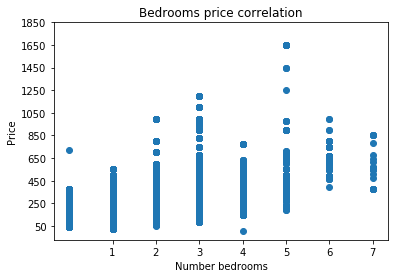

In [285]:
# Sort by the amount of bedrooms to plot it correctly
sorted_x = pd.DataFrame([X_train['bedrooms'], y_train]).T
sorted_x = sorted_x.sort_values(by=['price_y'])

plt.scatter(sorted_x.bedrooms, sorted_x.price_y)
plt.title("Bedrooms price correlation")
plt.xlabel("Number bedrooms")
plt.ylabel("Price")
plt.yticks(np.arange(50, 2000, 200))
plt.xticks(np.arange(1, len(set(sorted_x.bedrooms))))
plt.show()

### Linear Regression model to predict the y_price of the data with MAE as loss function

In [286]:
lr = linear_model.LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

mae = metrics.mean_absolute_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)

print("Mean absolute Error : {:9.2f}".format(round(mae, 2)))
print("Mean squared Error  : {:9.2f}".format(round(mse, 2)))

Mean absolute Error :     43.81
Mean squared Error  :   4952.16


## Importance of features

/Users/Loehr/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


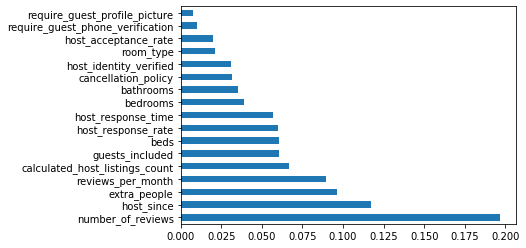

In [287]:
model = ExtraTreesClassifier()
model.fit(dataset[tags_x], y)
#print(model.feature_importances_)

feat_importances = pd.Series(model.feature_importances_, index=dataset[tags_x].columns)
feat_importances.nlargest(len(tags_x)).plot(kind='barh')
plt.show()

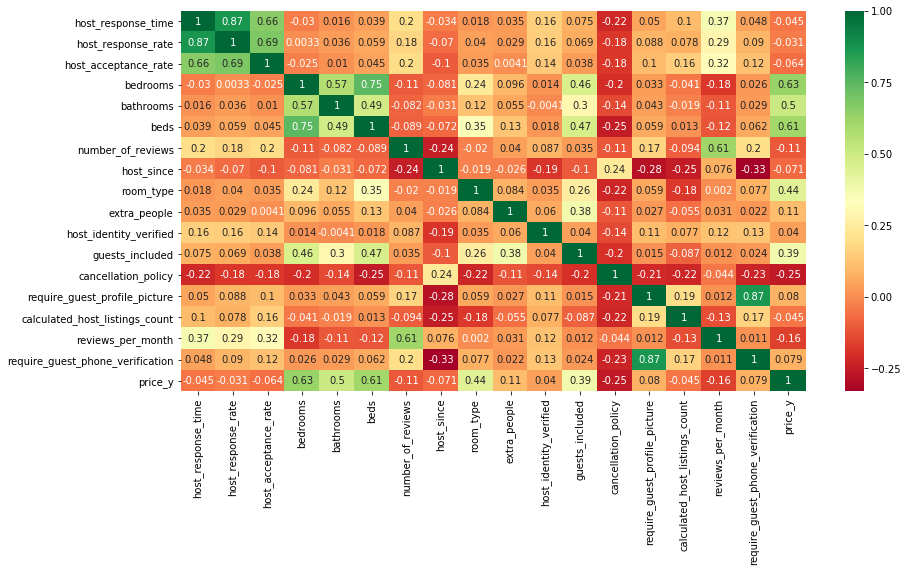

In [288]:
plt.figure(figsize=(14,7))
g=sns.heatmap(dataset2[tags].corr(), annot=True, cmap="RdYlGn")

In [293]:
# To fit the data into the Neural Network, we need to create a new dimension, because the LSTM model
# expect format like (12, 1), since our data is 104365 and 12 features, we need to reshape it to (104365, 12, 1)
# and cut away the first dimension when we give it as parameter to the neural net -> (12, 1)

Xtrain = np.array(X_train)

scaler = MinMaxScaler()
trainXn = scaler.fit_transform(Xtrain)

### LSTM Neural Network PyTorch

In [294]:
trainXs = trainXn[:,:, newaxis]
trainXs.shape

(104365, 17, 1)

In [296]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=trainXs.shape[-2:]))  
model.add(LSTM(32))
model.add(Dense(1))

model.compile(optimizer=tf.train.AdamOptimizer(learning_rate=0.05), loss='mae')
model.fit(trainXs, y_train, epochs=5, batch_size=2048)

Epoch 1/5
104365/104365 [==============================] - 47s 452us/step - loss: 105.7305
Epoch 2/5
104365/104365 [==============================] - 45s 429us/step - loss: 68.9599
Epoch 3/5
104365/104365 [==============================] - 47s 450us/step - loss: 63.8718
Epoch 4/5
104365/104365 [==============================] - 49s 469us/step - loss: 63.7930
Epoch 5/5
104365/104365 [==============================] - 45s 429us/step - loss: 63.7913


## I try to find out the vibe of the neighbourhood by doing sentiment analysis of the reviews of the customers and extract the peoples thoughts about the accommodation and city

In [345]:
data = dict()
# Stem the words to their origin:  played -> play
stemmer = SnowballStemmer("english")

# combine review with city name together in data array
for nh, overview in zip(listings['neighbourhood'].dropna().astype(str), listings['neighborhood_overview'].astype(str)):
    if(nh in data):
        data[nh] += overview
    else:
        data[nh] = overview

nb_vibe = {}
nb_freq = {} 
 
# Natural Language Processing Preprocessing for all the reviews
for nh in data:
    t = RegexpTokenizer(r'\w+')     # Get rid of .,?!"" and additional spaces
    tokens = t.tokenize(data[nh])   # Tokenize a sentence and splits it by a space
    
    stop_words = set(stopwords.words('english'))   # Remove Stopwords aka "and" or "with"
    stop_words2 = [*nh.lower().split(' '), 'seattle', 'neighborhood']   # lower the caps of the words
    
    # Apply all of that
    tokens = [w.lower() for w in tokens if not w in stop_words]
    tokens = [w for w in tokens if not w in stop_words2]
    tokens = [stemmer.stem(WordNetLemmatizer().lemmatize(token, pos='v')) for token in tokens]
    
    # Calculate the frequency count of the words
    frequency_dist = nltk.FreqDist(tokens)
    nb_freq[nh] = frequency_dist
    
    # I store the 50 most used words in the nb_vibe array
    nb_vibe[nh] = sorted(frequency_dist, key=frequency_dist.__getitem__, reverse=True)[0:50]

In [346]:
# Use the 6 citys with the most reviews to apply the 50 most frequent words on
max_words = {}
for nh in nb_vibe:
    max_words[nh] = len(data[nh])
    
top_reviewed_citys = sorted(max_words, key=max_words.get)[::-1][:6]
print(top_reviewed_citys)

['Capitol Hill', 'Ballard', 'Queen Anne', 'Belltown', 'Minor', 'Wallingford']


## Create Wordcloud to visualize the 50 most used words in the review

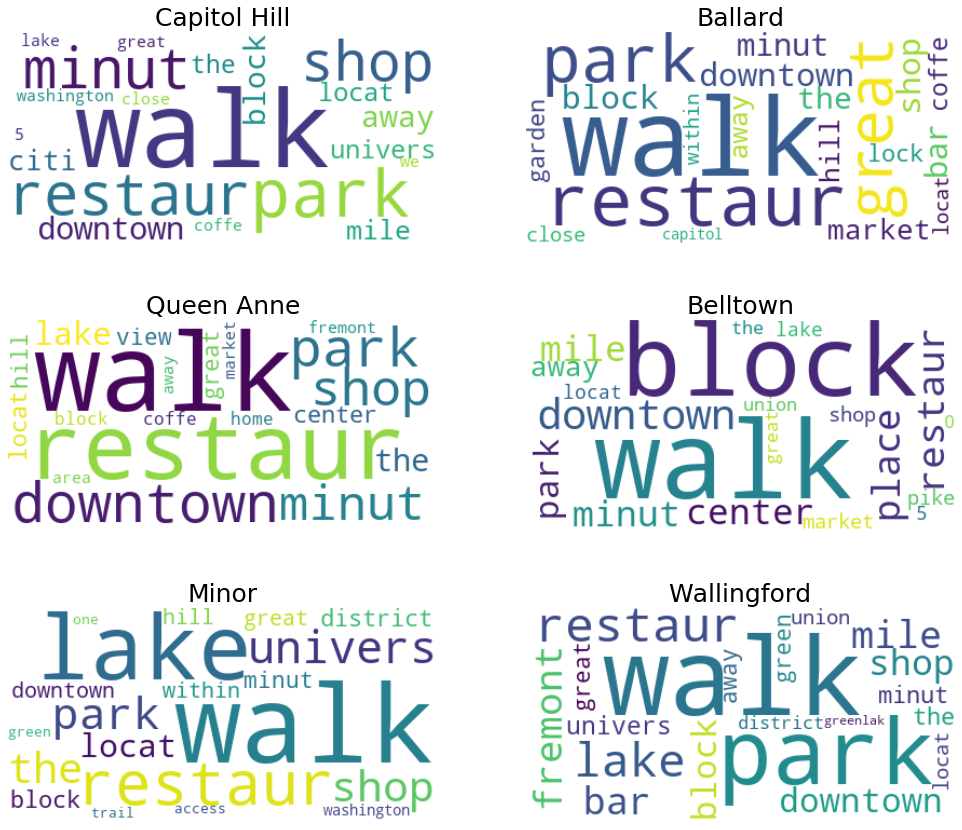

In [347]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(nrows=3, ncols=2, figsize=(17,15))
axs = [ax1, ax2, ax3, ax4, ax5, ax6]

for ax, city in zip(axs, top_reviewed_citys):
    wordcloud = WordCloud(max_font_size=100, 
                          max_words=20, background_color="white").generate_from_frequencies(nb_freq[city])
    ax.imshow(wordcloud, interpolation="bilinear")
    ax.axis("off")
    ax.set_title(city, fontsize=25)

In [348]:
nb = listings[['review_scores_value', 'neighbourhood']].dropna()
X = np.array(nb['neighbourhood'])
y = np.array(nb['review_scores_value'].astype(int))

print("X: Neighbourhood: " + str(X.shape))
print("Y: Score for the accommodation: " +str(y.shape))
print("Unique Neighbourhoods: " + str(len(set(X))))

X: Neighbourhood: (2858,)
Y: Score for the accommodation: (2858,)
Unique Neighbourhoods: 79


In [349]:
# Apply the scores to the unique citys
rating = dict()

for r, nb in zip(y, X):
    if(nb not in rating):
        rating[nb] = [r, 1]
    else:
        rating[nb][0] += r
        rating[nb][1] += 1

## To understand the value of a review score i visualize the all the scores the people gave to the airbnb accommodations. 

It seems that the people have a high tendencie to rate the accommodation pretty high, which results in rather unprecise analysis. The score of the review is nothing to highly rely on.

This is why i use the amount of reviews used for every city and not decide by the mean score

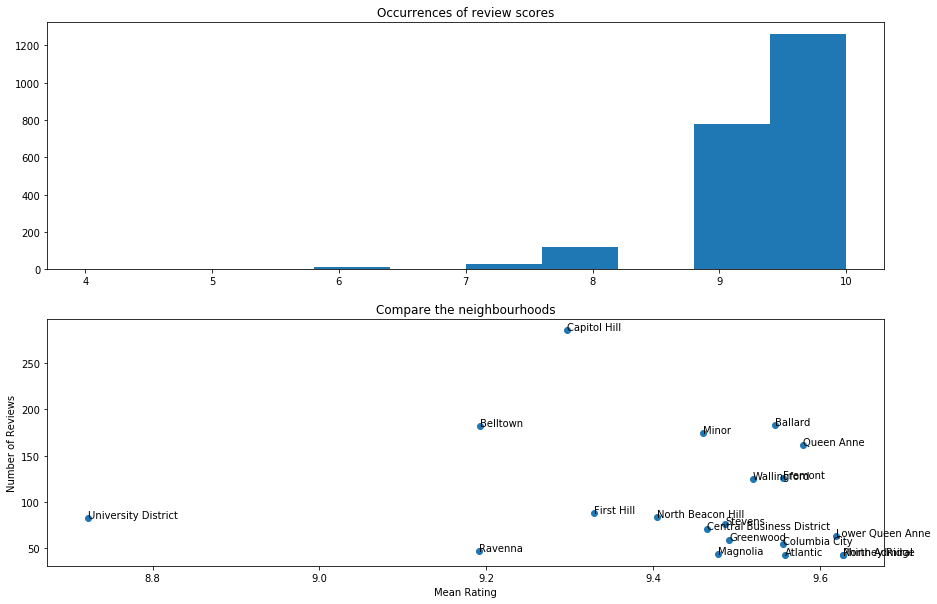

In [350]:
nb = listings[['neighborhood_overview', 'review_scores_value', 'neighbourhood']].dropna()
text = np.array(nb['neighborhood_overview'])
label = nb['review_scores_value'].astype(int)

# Sort, Sum and ocunt the ratings of all the citys
x = sorted(rating.items(), key=lambda x: x[1])[::-1][:20]
names = [x[0] for x in x]
x_sum = [x[1][0] for x in x]
y_count = [x[1][1] for x in x]
x_mean = []

for x, y in zip(x_sum, y_count):
    x_mean.append(x/y)

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15,10))
    
ax1.hist(label)
ax1.set_title("Occurrences of review scores")

for i, name in enumerate(names):
    ax2.annotate(name, (x_mean[i], y_count[i]))

ax2.scatter(x_mean, y_count)
ax2.set_title("Compare the neighbourhoods")
ax2.set_ylabel("Number of Reviews")
ax2.set_xlabel("Mean Rating")
plt.show()

# Busiest times of the year

In [351]:
calendar = calendar.dropna()
dates = calendar['date']
price = calendar['price']

year_date = {date: 0 for date in set(dates)}
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 
         'October', 'November', 'December', 'January']

for date in dates:
    year_date[date] += 1

# empty array to be filled with the monthly visitors per month
monthly_visitors = np.zeros(12)
    
year_num = []

# Iterate over all entries and append the single counts of customers
for i, date in enumerate(year_date.items()):
    year_num.append(date[1])
    
for date in year_date:
    monthly_visitors[int(date.split('-')[1]) - 1] += year_date[date]

monthly_visitors = [int(visitors) for visitors in monthly_visitors]

print("Monthly visitors for example for January: " +str(monthly_visitors[0]))

Monthly visitors for example for January: 64937


### I estimate the amount of visitors for the year 2017 with a Polynomial Linear Regression

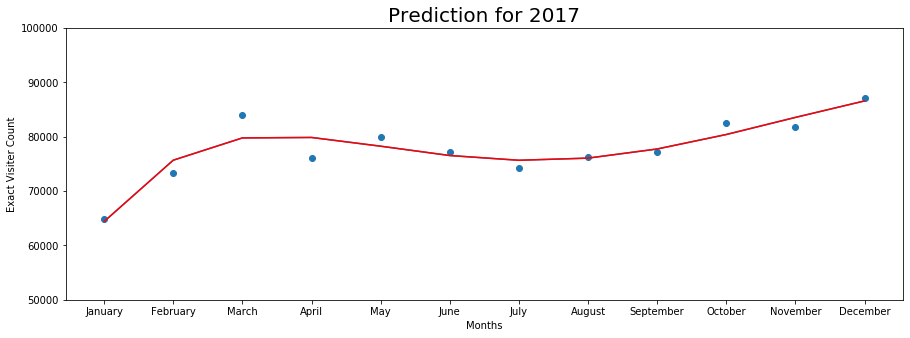

In [352]:
y = np.array(monthly_visitors)
X = np.array(np.arange(1, 13))

# Polynomial Regression expects a third dimension like the Neural Network (x, y, 1)
X = X[:, np.newaxis]
y = y[:, np.newaxis]

# Fit the Polynomial Regression
polynomial_features= PolynomialFeatures(degree=5)
x_poly = polynomial_features.fit_transform(X)

# Fit the Linear Regression
linreg = linear_model.LinearRegression()
linreg.fit(x_poly, y)

# Predict all months in 2017
y_poly_pred = linreg.predict(x_poly)

#print("Y = " + str(lr.coef_[0]) + "X + "+ str(round(lr.intercept_[0], 2)))

plt.figure(figsize=(15,5))
plt.scatter(X, y)
plt.plot(np.arange(1, len(y_poly_pred) + 1), y_poly_pred)
plt.plot(X, y_poly_pred, color="red")
plt.title("Prediction for 2017", fontsize=20)
plt.xlabel("Months")
plt.ylabel("Exact Visiter Count")
plt.yticks(np.arange(50000, 110000, 10000))
plt.xticks(np.arange(1, 13), months)
plt.show()

### I estimate the amount of daily visitors for the year 2016 with a Polynomial Linear Regression

Y = [ 0.00000000e+00  7.83689034e-01 -1.35114483e-02  7.07010844e-05
 -1.51061133e-07  1.09345944e-10]X + 2576.13


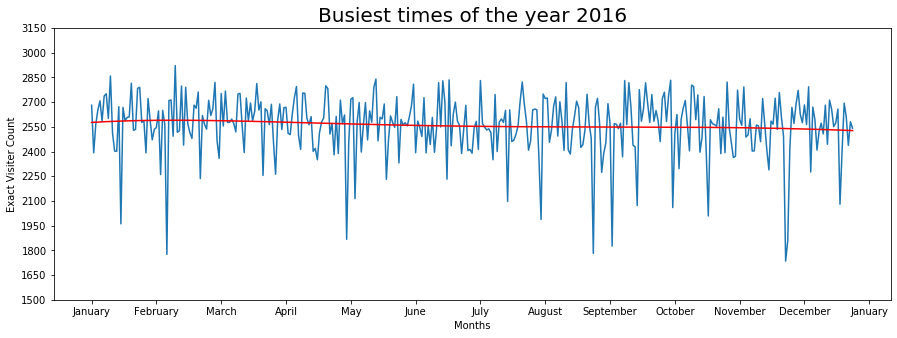

In [353]:
y = np.array(year_num)
X = np.array(np.arange(1, len(year_num) + 1))

# Polynomial Regression expects a third dimension like the Neural Network (x, y, 1)
X = X[:, np.newaxis]
y = y[:, np.newaxis]

# Fit the Polynomial Regression
polynomial_features= PolynomialFeatures(degree=5)
x_poly = polynomial_features.fit_transform(X)

# Fit the Linear Regression
lr = linear_model.LinearRegression()
lr.fit(x_poly, y)
y_pred = lr.predict(x_poly)

print("Y = " + str(lr.coef_[0]) + "X + "+ str(round(lr.intercept_[0], 2)))

plt.figure(figsize=(15,5))
plt.plot(np.arange(1, len(year_num) + 1), year_num)
plt.title("Busiest times of the year 2016", fontsize=20)
plt.xlabel("Months")
plt.ylabel("Exact Visiter Count")
plt.yticks(np.arange(1500, 3250, 150))
plt.xticks(np.arange(1, 395, 31), months)
plt.show()

## Actual occupation of the 3861 Airbnb accommodations

Since it was hard figure out when a flat is really occupied by a costumer or when a flat is just currently not available, because the owner doesn't want people to live in at the moment, i assume that a free flat counts as no visitor and a occupied flat counts as a costumer is living in the flat.

For this ratio between empty and occupied we did all the below calculations

In [354]:
# Create a new DataFrame
new_listings = listings2[['id', 'beds', 'availability_30', 'availability_365']] 

# Merge the Calendar and Listings DataFrame with neccessaty columns
availability = pd.merge(new_listings, calendar2, left_on='id', right_on='listing_id', 
                        how='left').drop('listing_id', axis=1)
# Little preprocessing
availability = availability.replace({"available" : {"t": 1, "f": 0}}).drop('price', 1)

# Devide and group by the free = 1 and occupied = 0 flats.
daily_available = availability.groupby([availability.date, availability.available]).count()
daily_available = np.array(daily_available['id'])

In [355]:
# Total Count of free and occupied days
daily_free = daily_available[::2]
daily_occupied = daily_available[1::2]

# Ratios of free and occupied days
daily_free_rate = (daily_free / (daily_free + daily_occupied))
daily_occupied_rate = (daily_occupied / (daily_free + daily_occupied))

## Plot of the ratio of the year 2016

Since I use the ratio, the y axis at 1 signals the 100%. We can observe, that in January there is more or less half of all flats available, whereas there are 3 main intervalls over the year.
Most people visit Seattle in April, end of June and Christmas.

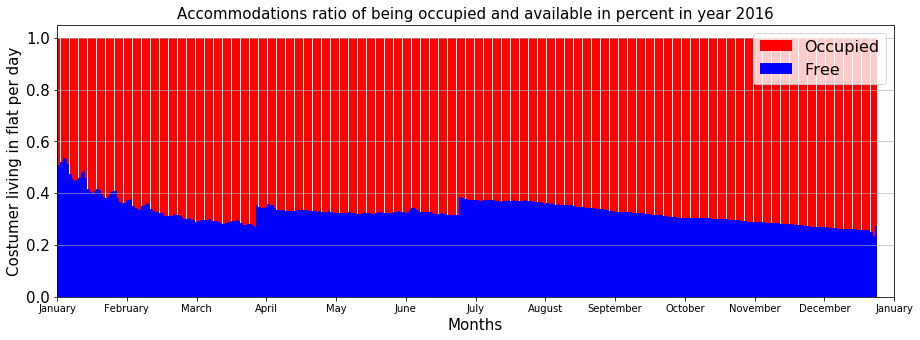

In [356]:
plt.figure(figsize=[15,5])
plt.bar(np.arange(1,366), daily_occupied_rate + daily_free_rate, width = 0.9, color='red',alpha=1, label="Occupied")
plt.bar(np.arange(1,366), daily_free_rate, width = 1, color='blue',alpha=1, label="Free")
plt.xlim(min(np.arange(1,366)), max(np.arange(1,366)))
plt.grid(axis='y', alpha=0.75)
plt.legend(['Occupied', 'Free'], prop={'size': 16})
plt.xlabel('Months',fontsize=15)
plt.ylabel('Total Capacity',fontsize=15)
plt.xticks(np.arange(1, 395, 31), months)
plt.yticks(fontsize=15)
plt.ylabel('Costumer living in flat per day',fontsize=15)
plt.title('Accommodations ratio of being occupied and available in percent in year 2016',fontsize=15)
plt.show()

In [357]:
# Preprocessing for the mean calculation. More complicated programmed then neccessary.
occupy_rate = pd.DataFrame()
occupy_rate = availability.groupby([availability.date]).count()
occupy_rate['rate'] = daily_occupied_rate
most_visited_days = occupy_rate.sort_values('rate')[::-1][:30]

# Assign new DataFrame
date_price = calendar
date_price = date_price[['date', 'price']].dropna(0)

date_price['price'] = [x.replace('$', '')[:-3] for x in date_price['price']]
date_price = date_price.sort_values(['date', 'price'])

x = np.array(date_price['date'])
y = np.array(date_price['price'])

x_set = np.array([x for x in set(x)])
x_set.shape

monthly_mean = {x: [] for x in np.arange(1,13)}

# Split date '2016-01-04' into ['2016', '01', '04'] to select by month
for date, price in zip(x, y):
    month = int(date.split('-')[1])
    price = price.replace(',', '')
    price = int(price)
    monthly_mean[month].append(price)

mean_prices = {x: 0 for x in np.arange(1,13)}

# Append all entries to a new array to calculate mean
for month in monthly_mean.items():
    value = 0
    for number in month[1]:
        value += int(number)
    value /= len(month[1])
    mean_prices[month[0]] = value

In [358]:
# Calculate the mean
mean_price = []
for price in mean_prices.items():
    mean_price.append(price[1])

## The price fluctuation over the year 2016

I can observe, that eventhough in christmas there is a peak of costumers, the price is rather low.
Whereas in the June and July sommer vacation time, in which also a lot of people arrive, we have the highest price. 

The flat owners apparently try to make the most money out of the flats in the summer time

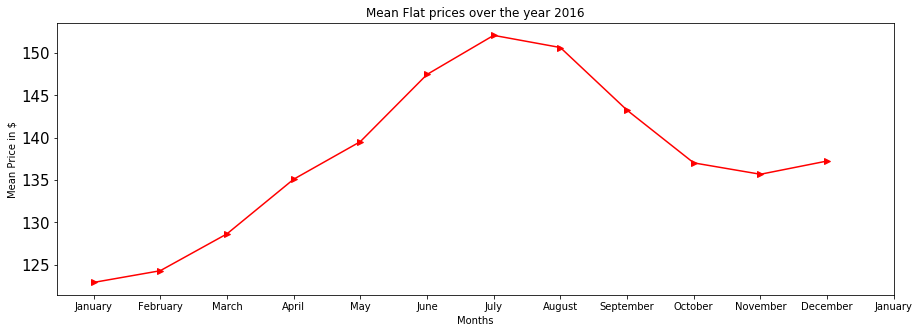

In [359]:
plt.figure(figsize=[15,5])
plt.title("Mean Flat prices over the year 2016")
plt.plot(np.arange(1, 13), mean_price, 'r->')
plt.ylabel("Mean Price in $")
plt.xlabel("Months")
plt.xticks(np.arange(1, 14), months)
plt.yticks(fontsize=15)
plt.show()